# Домашнее задание №1

В этом домашнем задании вам предлагается обучить модель регрессии для предсказания стоимости автомобилей, а также реализовать веб-сервис для применения построенной модели на новых данных.

> Оценка за домашку = min(ваш балл, 10)


Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода.

А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

In [164]:
import numpy as np
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random
import seaborn as sns
import re
import time
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error as MSE
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List
import pandas as pd
from sklearn.preprocessing import StandardScaler

random.seed(42)
np.random.seed(42)

In [74]:
from sklearn.preprocessing import OneHotEncoder

Ниже ответьте на вопрос <font color='#FF6600'>
"Для чего фиксируем сиды в домашках?"</font>

In [241]:
print("Фиксирование сидов необходимо для воспроизводимости данных (будут те же самые случайные последовательности при каждом запуске программы)")

Фиксирование сидов необходимо для воспроизводимости данных (будут те же самые случайные последовательности при каждом запуске программы)


# Часть 1 (2.5 балла + 0.75) | EDA

## Простейший EDA и обработка признаков (1.5 балла + 0.25)

In [165]:
df_train = pd.read_csv('https://raw.githubusercontent.com/hse-mlds/ml/main/hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/hse-mlds/ml/main/hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


(0.15 балла) <font color='#9933CC'>Отобразите 10 **случайных** строк тренировочного датасета</font>

In [4]:
df_train.sample(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
6565,Renault KWID Climber 1.0 MT BSIV,2019,300000,35000,Petrol,Individual,Manual,First Owner,23.01 kmpl,999 CC,67 bhp,91Nm@ 4250rpm,5.0
2943,Maruti Wagon R LXI,2013,225000,58343,Petrol,Trustmark Dealer,Manual,First Owner,21.79 kmpl,998 CC,67.05 bhp,90Nm@ 3500rpm,5.0
2024,Hyundai i20 Asta 1.2,2013,360000,30000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
263,Hyundai i20 1.2 Asta,2010,300000,70000,Petrol,Individual,Manual,First Owner,17.0 kmpl,1197 CC,80 bhp,"11.4 kgm at 4,000 rpm",5.0
4586,Skoda Octavia L and K 1.9 TDI MT,2005,250000,120000,Diesel,Individual,Manual,Third Owner,16.4 kmpl,1896 CC,90 bhp,"21.4@ 1,900(kgm@ rpm)",5.0
4479,Maruti Ciaz ZXi,2016,700000,20000,Petrol,Individual,Manual,First Owner,20.73 kmpl,1373 CC,91.1 bhp,130Nm@ 4000rpm,5.0
4881,Hyundai Grand i10 1.2 Kappa Magna BSIV,2017,445000,27000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
3583,Ford Ecosport 1.5 DV5 MT Trend,2016,515000,68609,Diesel,Dealer,Manual,First Owner,22.7 kmpl,1498 CC,89.84 bhp,204Nm@ 2000-2750rpm,5.0
6361,Hyundai Verna 1.4 VTVT,2014,500000,33400,Petrol,Individual,Manual,First Owner,17.43 kmpl,1396 CC,105.5 bhp,135.3Nm@ 5000rpm,5.0
4108,Hyundai i20 Era 1.2,2015,490000,45900,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0


(0.1 балла) <font color='#9933CC'>Отобразите первые 5 и последние 5 объектов тестового датасета</font>

In [245]:
# первые 5 строк
df_test.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0 kmpl,2498 CC,112 bhp,260 Nm at 1800-2200 rpm,7.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9 kmpl,1799 CC,130 bhp,172Nm@ 4300rpm,5.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5 kmpl,1172 CC,65 bhp,96 Nm at 3000 rpm,5.0


In [246]:
# последние 5 строк
df_test.tail()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
995,Hyundai i10 Magna 1.1L,2008,250000,100000,Petrol,Individual,Manual,Second Owner,19.81 kmpl,1086 CC,68.05 bhp,99.04Nm@ 4500rpm,5.0
996,Hyundai i20 2015-2017 Sportz 1.2,2017,440000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0
997,Hyundai i20 Era Diesel,2009,340000,40000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
998,Hyundai i10 Asta,2012,350000,25000,Petrol,Individual,Manual,First Owner,20.36 kmpl,1197 CC,78.9 bhp,111.8Nm@ 4000rpm,5.0
999,Honda City i DTec SV,2016,700000,110000,Diesel,Individual,Manual,First Owner,26.0 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0


(0.1 балла) <font color='#9933CC'>Посчитайте основные статистики как по числовым, так и по категориальным столбцам для трейна и теста</font>. 
> Подсказка: ``.describe()`` с нужным(и) аргументом(-ами)



In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6999 non-null   object 
 1   year           6999 non-null   int64  
 2   selling_price  6999 non-null   int64  
 3   km_driven      6999 non-null   int64  
 4   fuel           6999 non-null   object 
 5   seller_type    6999 non-null   object 
 6   transmission   6999 non-null   object 
 7   owner          6999 non-null   object 
 8   mileage        6797 non-null   object 
 9   engine         6797 non-null   object 
 10  max_power      6803 non-null   object 
 11  torque         6796 non-null   object 
 12  seats          6797 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 711.0+ KB


In [14]:
df_train.describe(include='all')

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
count,6999,6999.000000,6.999000e+03,6.999000e+03,6999,6999,6999,6999,6797,6797,6803,6796,6797.000000
unique,1924,NaN,NaN,NaN,4,3,2,5,386,120,316,419,NaN
top,Maruti Swift Dzire VDI,NaN,NaN,NaN,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,NaN
freq,116,NaN,NaN,NaN,3793,5826,6095,4587,197,885,330,468,NaN
mean,NaN,2013.818403,6.395152e+05,6.958462e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.419008
std,NaN,4.053095,8.089419e+05,5.772400e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.965767
min,NaN,1983.000000,2.999900e+04,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000
25%,NaN,2011.000000,2.549990e+05,3.500000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
50%,NaN,2015.000000,4.500000e+05,6.000000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
75%,NaN,2017.000000,6.750000e+05,9.700000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000


In [15]:
df_test.describe(include='all')

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
count,1000,1000.000000,1.000000e+03,1000.000000,1000,1000,1000,1000,981,981,981,981,981.000000
unique,621,NaN,NaN,NaN,4,3,2,5,237,88,182,226,NaN
top,Maruti Alto 800 LXI,NaN,NaN,NaN,Diesel,Individual,Manual,First Owner,18.6 kmpl,1248 CC,74 bhp,200Nm@ 1750rpm,NaN
freq,15,NaN,NaN,NaN,534,837,877,623,23,116,43,57,NaN
mean,NaN,2013.681000,6.179010e+05,71393.341000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.410805
std,NaN,4.012149,7.585539e+05,48486.218662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.919985
min,NaN,1995.000000,3.100000e+04,1303.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000
25%,NaN,2011.000000,2.500000e+05,37000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
50%,NaN,2014.000000,4.349990e+05,61500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
75%,NaN,2017.000000,6.700000e+05,100000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000


(0.15 балла) <font color='#9933CC'>Посмотрите, есть ли в датасете пропуски.</font>

<font color='#FF6600'>Если есть, то в каких колонках?</font>

In [16]:
df_train.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          202
engine           202
max_power        196
torque           203
seats            202
dtype: int64

In [247]:
df_test.isna().sum()

name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage          19
engine           19
max_power        19
torque           19
seats            19
dtype: int64

In [12]:
df_train.loc[:, df_train.isna().sum() > 0].columns

Index(['mileage', 'engine', 'max_power', 'torque', 'seats'], dtype='object')

Видим пропуски в 5 колонках: `mileage`, `engine`, `max_power`, `torque`, `seats`

(0.1 балла) <font color='#9933CC'>Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием</font> (целевую переменную следует исключить). Если есть, то сколько?

In [13]:
feature_columns = df_train.columns.difference(['selling_price'])  # selling_price - целевая переменная
duplicates = df_train.duplicated(subset=feature_columns, keep=False) # bool колонка, которую применим как маску в дальнейшнем

duplicates = df_train[df_train.duplicated(subset=feature_columns, keep=False)]

In [14]:
print(f'Количество дубликатов в трейновом датасете с одинаковым признаковым описанием: {duplicates.shape[0]}')

Количество дубликатов в трейновом датасете с одинаковым признаковым описанием: 1799


(0.15 балла) <font color='#9933CC'>Отобразите такие объекты</font>

In [249]:
duplicates.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
22,Maruti Baleno Delta 1.2,2016,575000,45000,Petrol,Individual,Manual,First Owner,21.4 kmpl,1197 CC,83.1 bhp,115Nm@ 4000rpm,5.0
26,Maruti Omni E MPI STD BS IV,2018,254999,25000,Petrol,Individual,Manual,First Owner,16.8 kmpl,796 CC,34.2 bhp,59Nm@ 2500rpm,8.0
27,Maruti Vitara Brezza LDi Option,2017,670000,70000,Diesel,Individual,Manual,First Owner,24.3 kmpl,1248 CC,88.5 bhp,200Nm@ 1750rpm,5.0
28,Fiat Palio 1.2 ELX,2003,70000,50000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
29,Maruti Omni 8 Seater BSIV,2012,150000,35000,Petrol,Individual,Manual,Second Owner,14.0 kmpl,796 CC,35 bhp,6.1kgm@ 3000rpm,5.0


In [285]:
# пример
duplicates[duplicates['name'] == 'Maruti Omni E MPI STD BS IV']

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
26,Maruti Omni E MPI STD BS IV,2018,254999,25000,Petrol,Individual,Manual,First Owner,16.8 kmpl,796 CC,34.2 bhp,59Nm@ 2500rpm,8.0
1581,Maruti Omni E MPI STD BS IV,2018,260000,30000,Petrol,Individual,Manual,First Owner,16.8 kmpl,796 CC,34.2 bhp,59Nm@ 2500rpm,8.0
2419,Maruti Omni E MPI STD BS IV,2018,200000,25000,Petrol,Individual,Manual,First Owner,16.8 kmpl,796 CC,34.2 bhp,59Nm@ 2500rpm,8.0
2929,Maruti Omni E MPI STD BS IV,2018,260000,30000,Petrol,Individual,Manual,First Owner,16.8 kmpl,796 CC,34.2 bhp,59Nm@ 2500rpm,8.0


(0.15 балла) <font color='#9933CC'>Удалите повторяющиеся строки</font>. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю

In [15]:
df_train = df_train[~df_train.duplicated(subset=feature_columns, keep='first')]
df_train.shape

(5840, 13)

In [629]:
assert df_train.shape == (5840, 13)

(0.1 балла) Чтоб все было по красоте, <font color='#9933CC'>обновите индексы строк таким образом, чтобы они шли от 0 без пропусков</font>

In [16]:
df_train = df_train.reset_index(drop=True)
df_train.tail()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92 kmpl,1086 CC,62.1 bhp,96.1Nm@ 3000rpm,5.0
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.9 kmpl,998 CC,67.1 bhp,90Nm@ 3500rpm,5.0
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0
5839,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0


Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не слава богу. Давайте починим.

(0.25 балла) Задача такая: 
<font color='#9933CC'>
* убрать единицы измерения для признаков ``mileage, engine, max_power``. 
* кастануть эти столбцы столбцы к ``float``.
* удалить столбец ``torque``
</font>

> Все действия нужно производить над обоими датасетами

---
**Доп (0.25 балла):**
* <font color='#9933CC'>Вместо удаления признак `torque` разделите на два: собственно `torque` и `max_torque_rpm`.</font> Учтите единицы измерения. Они разные ☹

(0.15 балла) <font color='#9933CC'>Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось</font>

> Обратите внимание, что, по уму, нужно посчитать медиану по трейну и этим средним заполнять пропуски в тесте. Так же делаем, если, например, стандартизируем признаки.



In [27]:
df_train.torque.unique()

array(['190Nm@ 2000rpm', '250Nm@ 1500-2500rpm',
       '22.4 kgm at 1750-2750rpm', '11.5@ 4,500(kgm@ rpm)',
       '113.75nm@ 4000rpm', '7.8@ 4,500(kgm@ rpm)', '59Nm@ 2500rpm',
       '170Nm@ 1800-2400rpm', '160Nm@ 2000rpm', '248Nm@ 2250rpm',
       '78Nm@ 4500rpm', nan, '84Nm@ 3500rpm', '115Nm@ 3500-3600rpm',
       '62Nm@ 3000rpm', '219.7Nm@ 1500-2750rpm', '200Nm@ 1750rpm',
       '115Nm@ 4000rpm', '69Nm@ 3500rpm', '172.5Nm@ 1750rpm',
       '6.1kgm@ 3000rpm', '60Nm@ 3500rpm', '90Nm@ 3500rpm',
       '151Nm@ 4850rpm', '104Nm@ 4000rpm', '320Nm@ 1700-2700rpm',
       '250Nm@ 1750-2500rpm', '145Nm@ 4600rpm', '146Nm@ 4800rpm',
       '343Nm@ 1400-3400rpm', '200Nm@ 1400-3400rpm',
       '200Nm@ 1250-4000rpm', '400Nm@ 2000-2500rpm',
       '360Nm@ 1200-3400rpm', '200Nm@ 1200-3600rpm',
       '380Nm@ 1750-2500rpm', '400Nm@ 1750-3000rpm',
       '400Nm@ 1400-2800rpm', '200Nm@ 1750-3000rpm', '111.7Nm@ 4000rpm',
       '219.6Nm@ 1500-2750rpm', '112Nm@ 4000rpm', '250Nm@ 1500-3000rpm',
       '1

1 kg/m = 9.8066 N/m

Чтобы разбить данные в столбце `torque` на два нужно учесть:
1. NaN
2. Nm и kg  для столбца `torque` (перевести 1 kg/m = 9.8066 N/m)    
3. rpm для `max_torque_rpm` (нужно взять максимум, поэтому если указан диапазон, берем последнее значение (150 в 100-150)) + есть случаи 4000+/-500, например, я в таком случае беру не 4500, а 4000
4. float могут быть написаны через . , а запятые в числах через , 

In [28]:
def split_torque_column(row: str):
    if pd.isna(row):
        return np.nan, np.nan
    
    lower_str = row.lower()
    
    numbers_pattern = re.findall(r'\d+(?:[.,]\d+)?', lower_str)
    numbers = [number.replace(',', '') for number in numbers_pattern]
    units = re.findall(r'nm|kgm|rpm', lower_str)

    torque_value = float(numbers[0])

    torque = torque_value if 'nm' in units else round(torque_value * 9.8066, 2)

    max_torque_rpm = float(numbers[-1]) if not '+/-' in row else float(numbers[-2])

    return torque, max_torque_rpm

In [29]:
df_train[['torque', 'max_torque_rpm']] = df_train['torque'].apply(lambda x: pd.Series(split_torque_column(x)))
df_test[['torque','max_torque_rpm']] = df_test['torque'].apply(lambda x: pd.Series(split_torque_column(x)))

In [30]:
df_train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190.00,5.0,2000.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250.00,5.0,2500.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,219.67,5.0,2750.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,112.78,5.0,4500.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75,5.0,4000.0


In [31]:
def check_measure(df:pd.DataFrame, col_name:str):
    df_without_na = df[~df[col_name].isna()]
    return df_without_na[col_name].apply(lambda x: x.split()[-1]).unique()

for col in ['mileage', 'engine', 'max_power']:
    print(f'В колонке {col} train единицы измерения: {check_measure(df_train, col)}')
    print(f'В колонке {col} test единицы измерения: {check_measure(df_test, col)}')

В колонке mileage train единицы измерения: ['kmpl' 'km/kg']
В колонке mileage test единицы измерения: ['kmpl' 'km/kg']
В колонке engine train единицы измерения: ['CC']
В колонке engine test единицы измерения: ['CC']
В колонке max_power train единицы измерения: ['bhp' '0']
В колонке max_power test единицы измерения: ['bhp']


Где только одно уникальное значение, просто отбрасываем его, остальное смотрим дальше

In [644]:
# 0 будем расценивать как Nan
df_train[(df_train.max_power.apply(lambda x: str(x)[-3:] != 'bhp')) & ~(df_train.max_power.isna())] 

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
476,Maruti Alto K10 LXI,2011,204999,97500,Petrol,Individual,Manual,First Owner,NaN,NaN,0,NaN,NaN,NaN
1112,Maruti Swift Dzire VDI Optional,2017,589000,41232,Diesel,Dealer,Manual,First Owner,NaN,NaN,0,NaN,NaN,NaN
2003,Tata Indica Vista Quadrajet LS,2012,240000,70000,Diesel,Individual,Manual,First Owner,NaN,NaN,0,NaN,NaN,NaN


Надо перевести km/kg в km/l 
    
V = m / p 

p(бензина) = 750 кг/м3 = 0.75 кг/л

Значит в одном кг бензина 1/0.75 литра

In [32]:
def convert_to_kmpl(mileage):
    mil = float(str(mileage).split()[0])
    if 'km/kg' in str(mileage):
        return mil * 0.75
    else:
        return mil

In [33]:
def convert_to_numeric(df):
    df['engine'] = df['engine'].apply(lambda x: str(x).split()[0])
    df['mileage'] = df['mileage'].apply(convert_to_kmpl)
    df['max_power'] = df['max_power'].replace('0', np.nan)
    df['max_power'] = df['max_power'].apply(lambda x: str(x)[:-4])
    numeric_cols = ['engine', 'max_power']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

def fill_with_median(df_train, df_test, cols=['engine', 'max_power','mileage','torque','max_torque_rpm']):
    medians = df_train[cols].median()
    seat_mode = df_train['seats'].mode()[0]
    df_train[cols] = df_train[cols].fillna(medians)
    df_train['seats'] = df_train['seats'].fillna(seat_mode)
    df_test[cols] = df_test[cols].fillna(medians)    
    df_test['seats'] = df_test['seats'].fillna(seat_mode)

    print(df_train.isna().sum())
    print(df_test.isna().sum())

In [34]:
convert_to_numeric(df_train)
convert_to_numeric(df_test)

In [35]:
fill_with_median(df_train, df_test)

name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage           0
engine            0
max_power         0
torque            0
seats             0
max_torque_rpm    0
dtype: int64
name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage           0
engine            0
max_power         0
torque            0
seats             0
max_torque_rpm    0
dtype: int64



(0.1 балла) Теперь, когда не осталось пропусков, можно <font color='#9933CC'>преобразовать столбцы к более подходящим типам (``engnine`` и ``seats`` к int)
</font>

Ниже ответьте, <font color='#FF6600'>почему (хоть мы этого и не делаем) ``seats``, возможно, лучше сделать переменной категориальной, а не целочисленной.</font>

In [36]:
cols = ['engine', 'seats']

df_train[cols] = df_train[cols].astype(int)
df_test[cols] = df_test[cols].astype(int)

In [ ]:
print("Дискретный признак, где само значение  ")

<Место для ответа на вопрос про seats>


## Визуализации (1 балл + 0.5)

Визуализировать нам надо не так уж и много. Во-первых, хотелось бы, в принципе, увидеть как распределены значения признаков. Также хотелось бы понять, насколько признаки скоррелированы между собой и с целевой переменной. А ещё неплохо бы посмотреть, не оказалось ли так, что тестовые данные распределены иначе, чем трейн.

Этим всем и предлагаем вам заняться.

(0.25 балла) <font color='#9933CC'>Посторойте попарные распределения всех числовых признаков для трейна.</font>

> ``sns.paiplot()`` позволяет сделать это в одну строчку

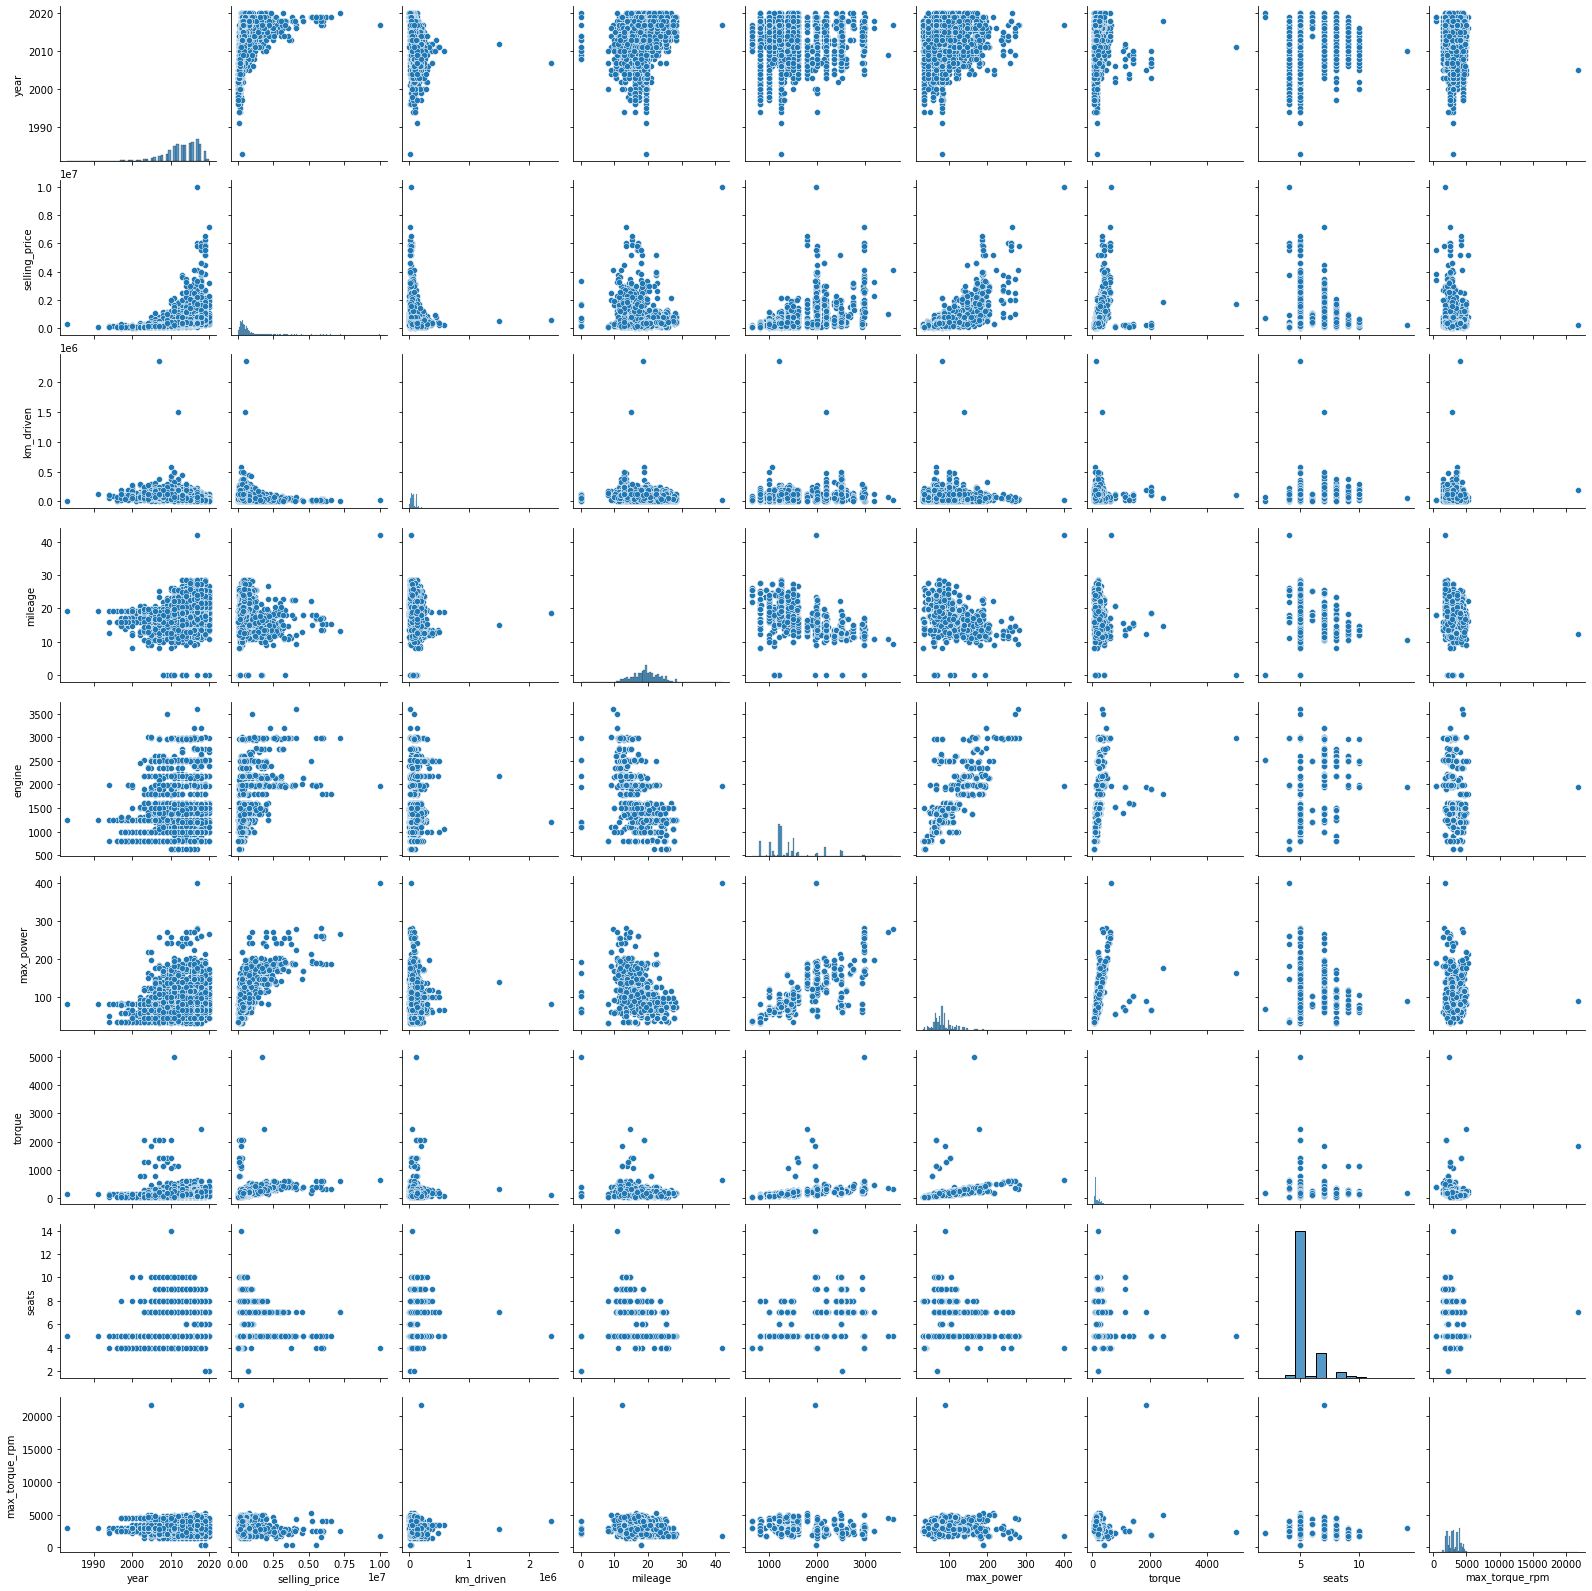

In [654]:
sns.pairplot(df_train)

Этот график не такой информативный, как можно было бы построить, беря признаки по отдельности. Но он позволяет сделать некоторые (возможно, далеко идущие) выводы. Впрочем, со многими из них (если не со всеми) вы бы справились умозрительно. Однако всегда приятно делать выводы, основываясь на данных.



* <font color='#FF6600'> Что можно сказать о связи предикторов с целевой переменной?
* А о корреляциях признаков? </font>

По графику между целевой переменной и предикторами `year`, `engine`, `seats`, `torque` особой зависимости нет, а вот с `max_power` кажется, что есть

(0.25 балла) <font color='#9933CC'>Постройте pairplot по тестовым данным</font> и ответьте на вопрос <font color='#FF6600'>"Похожими ли оказались совокупности при разделении на трейн и тест?"</font>

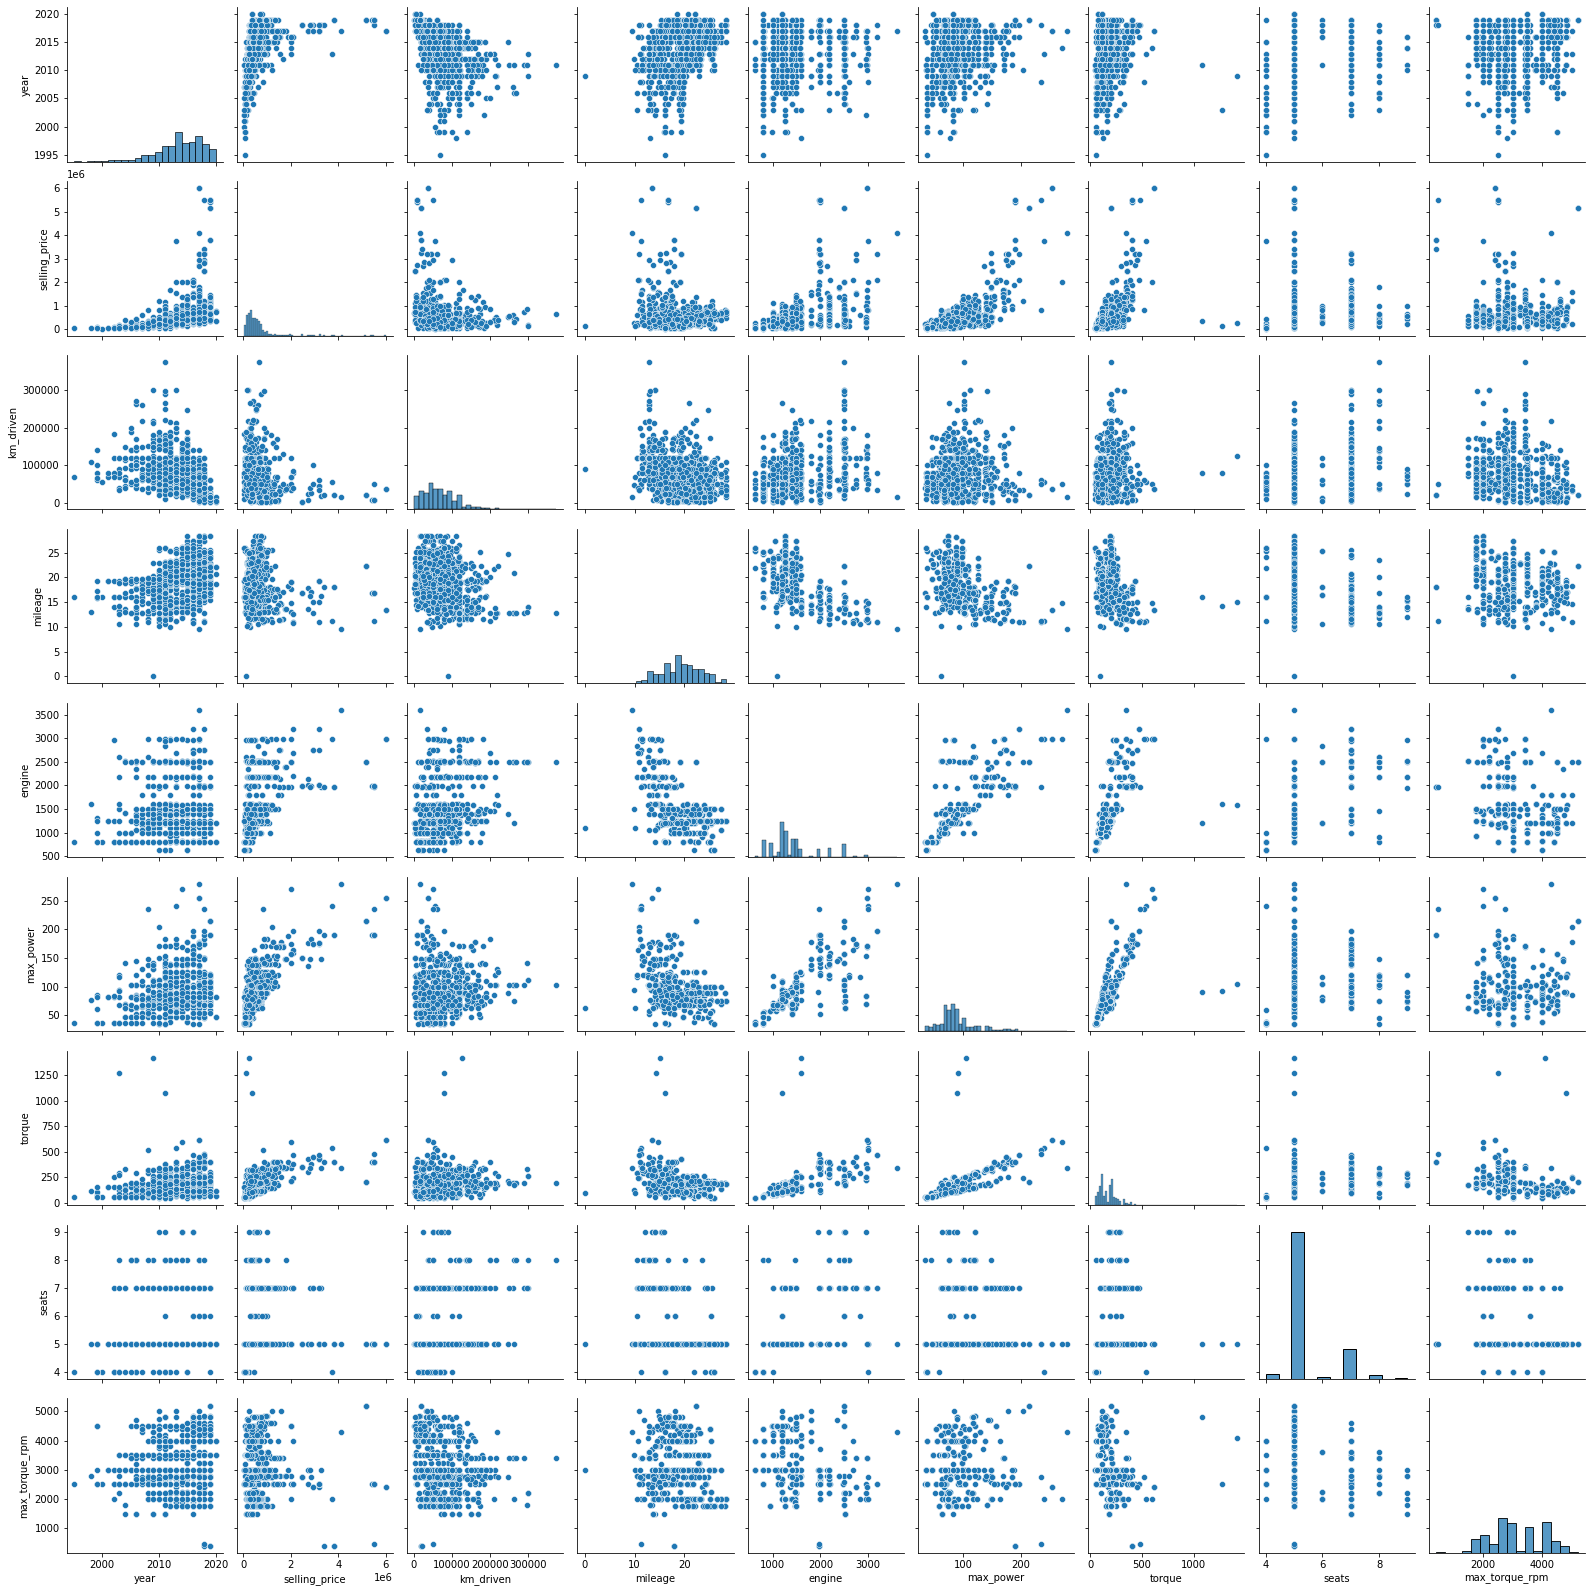

In [651]:
sns.pairplot(df_test)

(0.25 балла) <font color='#9933CC'>Для трейна давайте построим тепловую карту (heatmap из библиотеки seaborn) попарных корреляций числовых колонок</font>

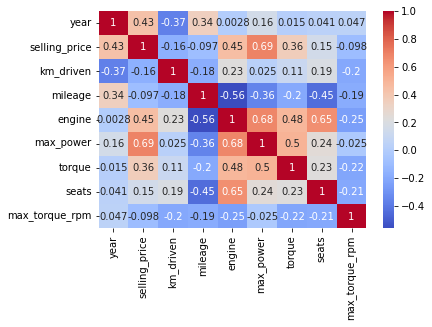

In [663]:
numeric_columns = df_train.select_dtypes(include=['number'])
correlation = numeric_columns.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

In [665]:
correlation.abs().min().sort_values(ascending=True)

year              0.002819
engine            0.002819
torque            0.014656
km_driven         0.024539
max_power         0.024539
max_torque_rpm    0.024786
seats             0.041178
selling_price     0.096703
mileage           0.096703
dtype: float64

In [667]:
correlation[correlation < 1].max().sort_values(ascending=False)

selling_price     0.693742
max_power         0.693742
engine            0.681968
seats             0.652172
torque            0.503556
year              0.427279
mileage           0.342957
km_driven         0.229766
max_torque_rpm    0.046724
dtype: float64

Ответьте, пожалуйста, на вопросы: 
* <font color='#FF6600'>Какие 2 признака наименее скоррелированы между собой?</font>
* <font color='#FF6600'>Между какими наблюдается довольно сильная положительная линейная зависимость?</font>
* <font color='#FF6600'>Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи.</font>

1. Наименее скореллированными между собой признаками будут те, у которых значение будет ближе всего к 0. Значит `year` и   `engine` наименее скореллированные
2. Между `max_power` и `selling_price` имеется сильная положительная линейная зависимость (0.69), однако `selling_price` - целевая переменная, а среди признаков  между `max_power` и `engine` (0.68)
3. Согласно тепловой карте, у признаков `year` и `km_driven` имеется слабая обратная корреляция, т.е определенная зависимость есть, но не явная

(0.25 балла) <font color='#9933CC'> Отобразите диаграммe рассеяния для наиболее скореллированной пары **признаков** (на трейне) </font>

Наиболее скореллированная пара признаков

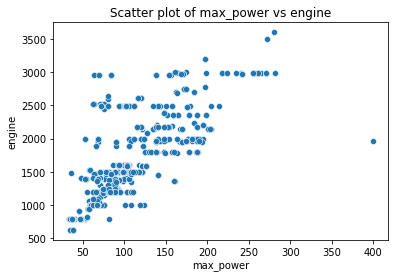

In [668]:
sns.scatterplot(x='max_power', y='engine', data=df_train)
plt.title(f'Scatter plot of max_power vs engine')
plt.show()

### Дополнительные визуализации (бонус 0.5 балла)

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

In [38]:
df_train['selling_price'].min()

29999

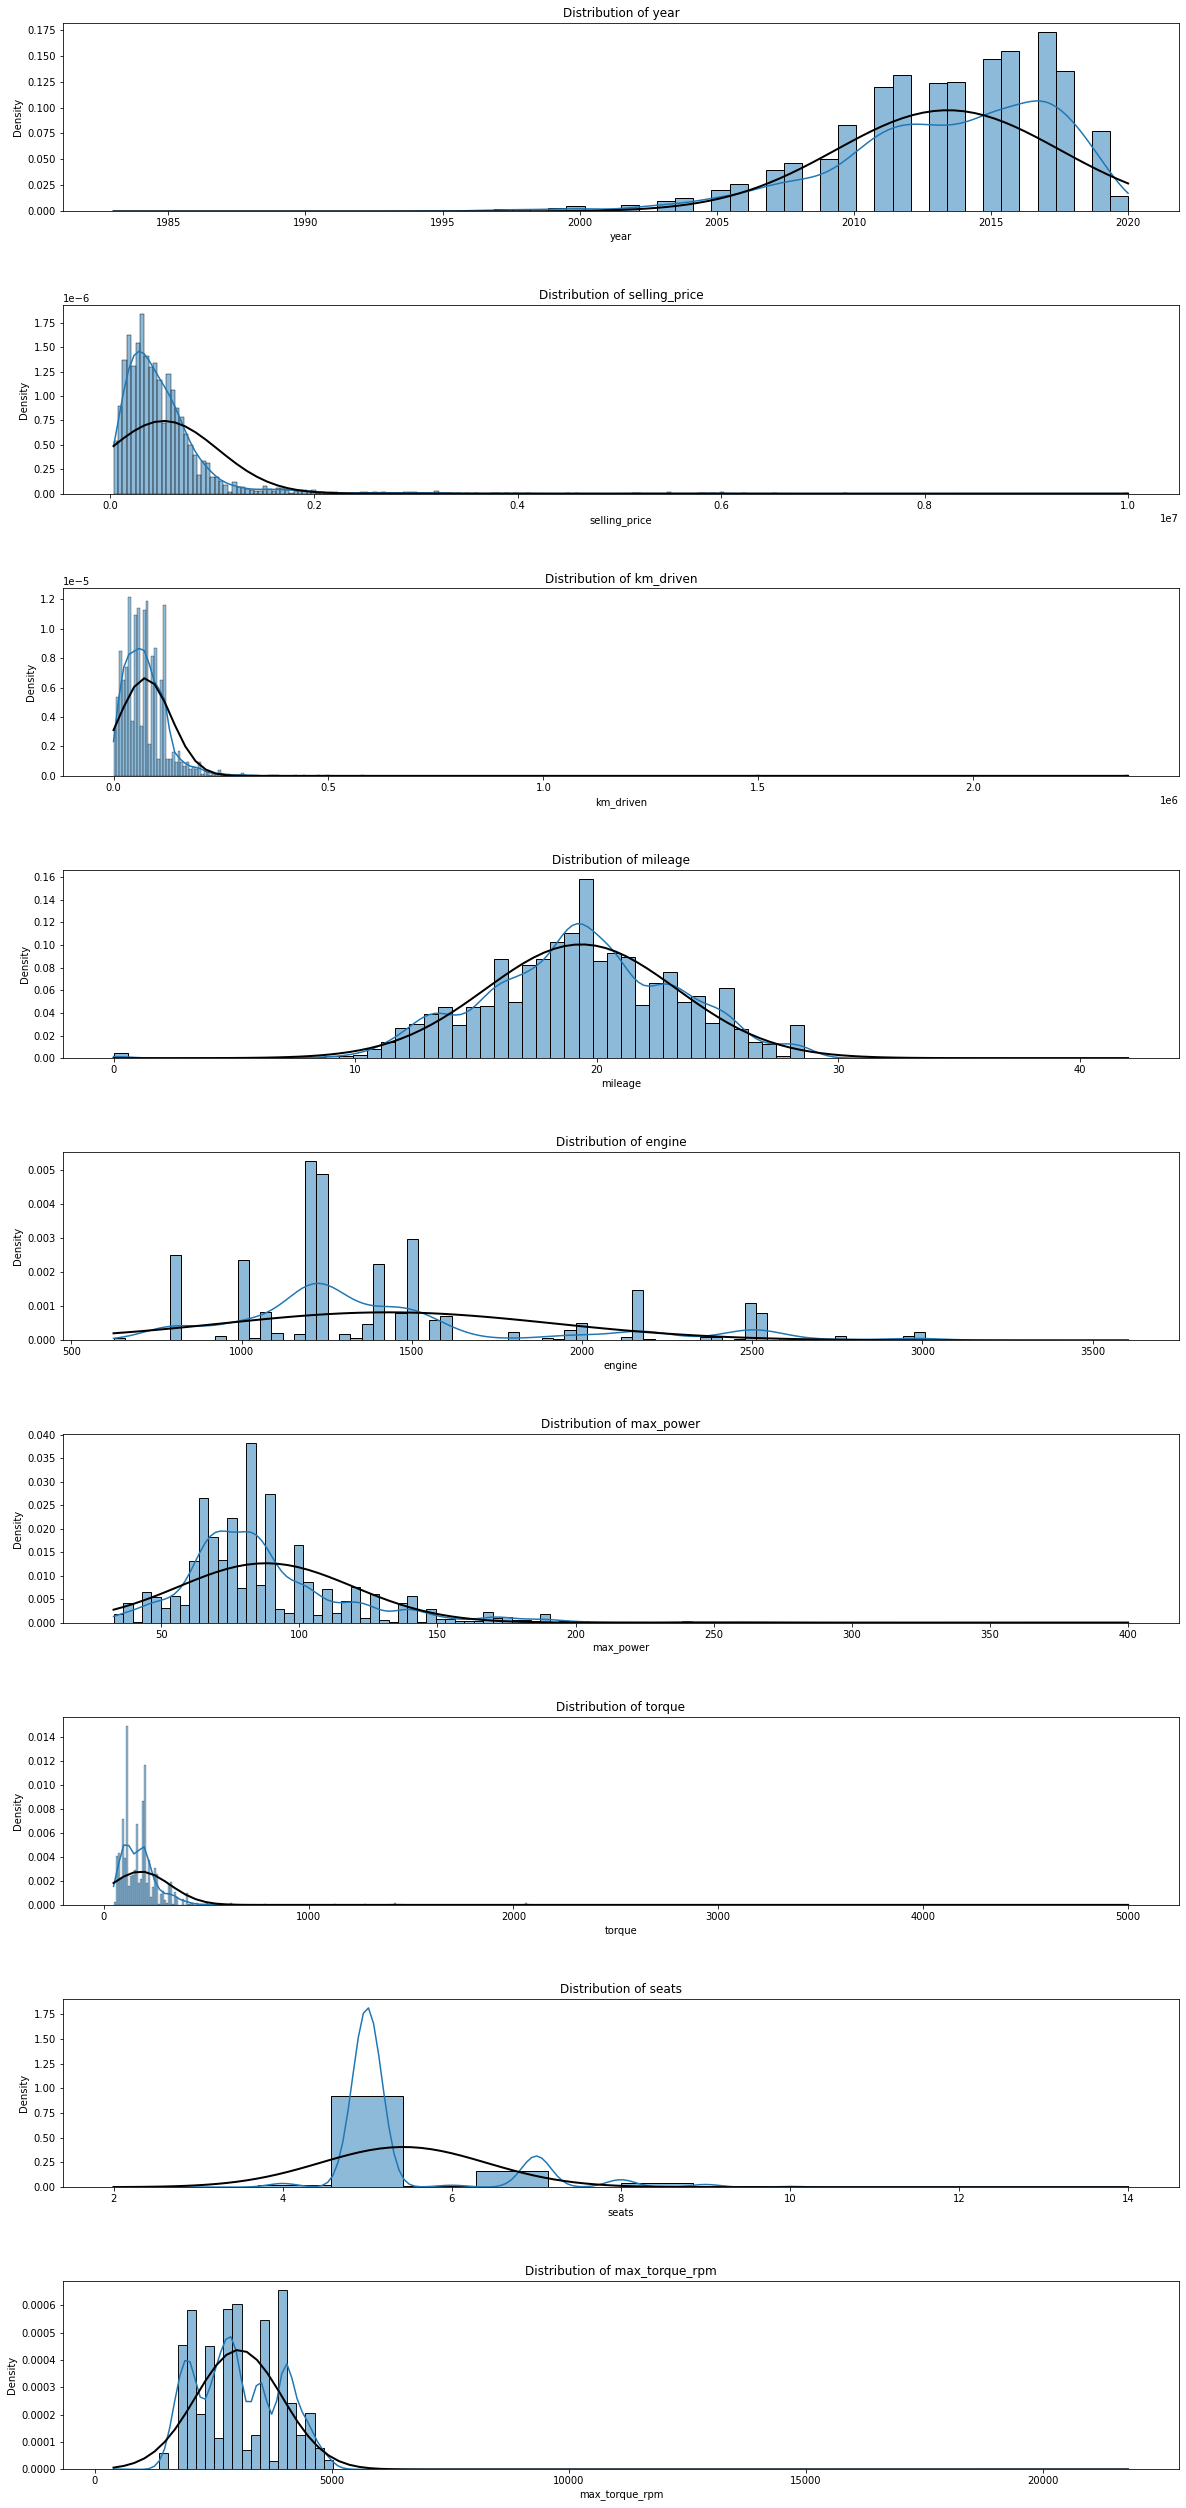

In [42]:
from scipy.stats import norm

numeric_columns = df_train.select_dtypes(include=['float64', 'int64']).columns

fig, axes = plt.subplots(nrows=len(numeric_columns), figsize=(20, 5 * len(numeric_columns)))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(numeric_columns):
    sns.histplot(df_train[col], kde=True, ax=axes[i],stat='density')
    axes[i].set_title(f'Distribution of {col}')
    axes[i]
    
    xmin, xmax = df_train[col].min(), df_train[col].max()
    mu, std = df_train[col].mean(), df_train[col].std()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[i].plot(x, p, 'k', linewidth=2)

plt.show()

У `selling_price` смещение пика влево, можно прологарфмировать значения

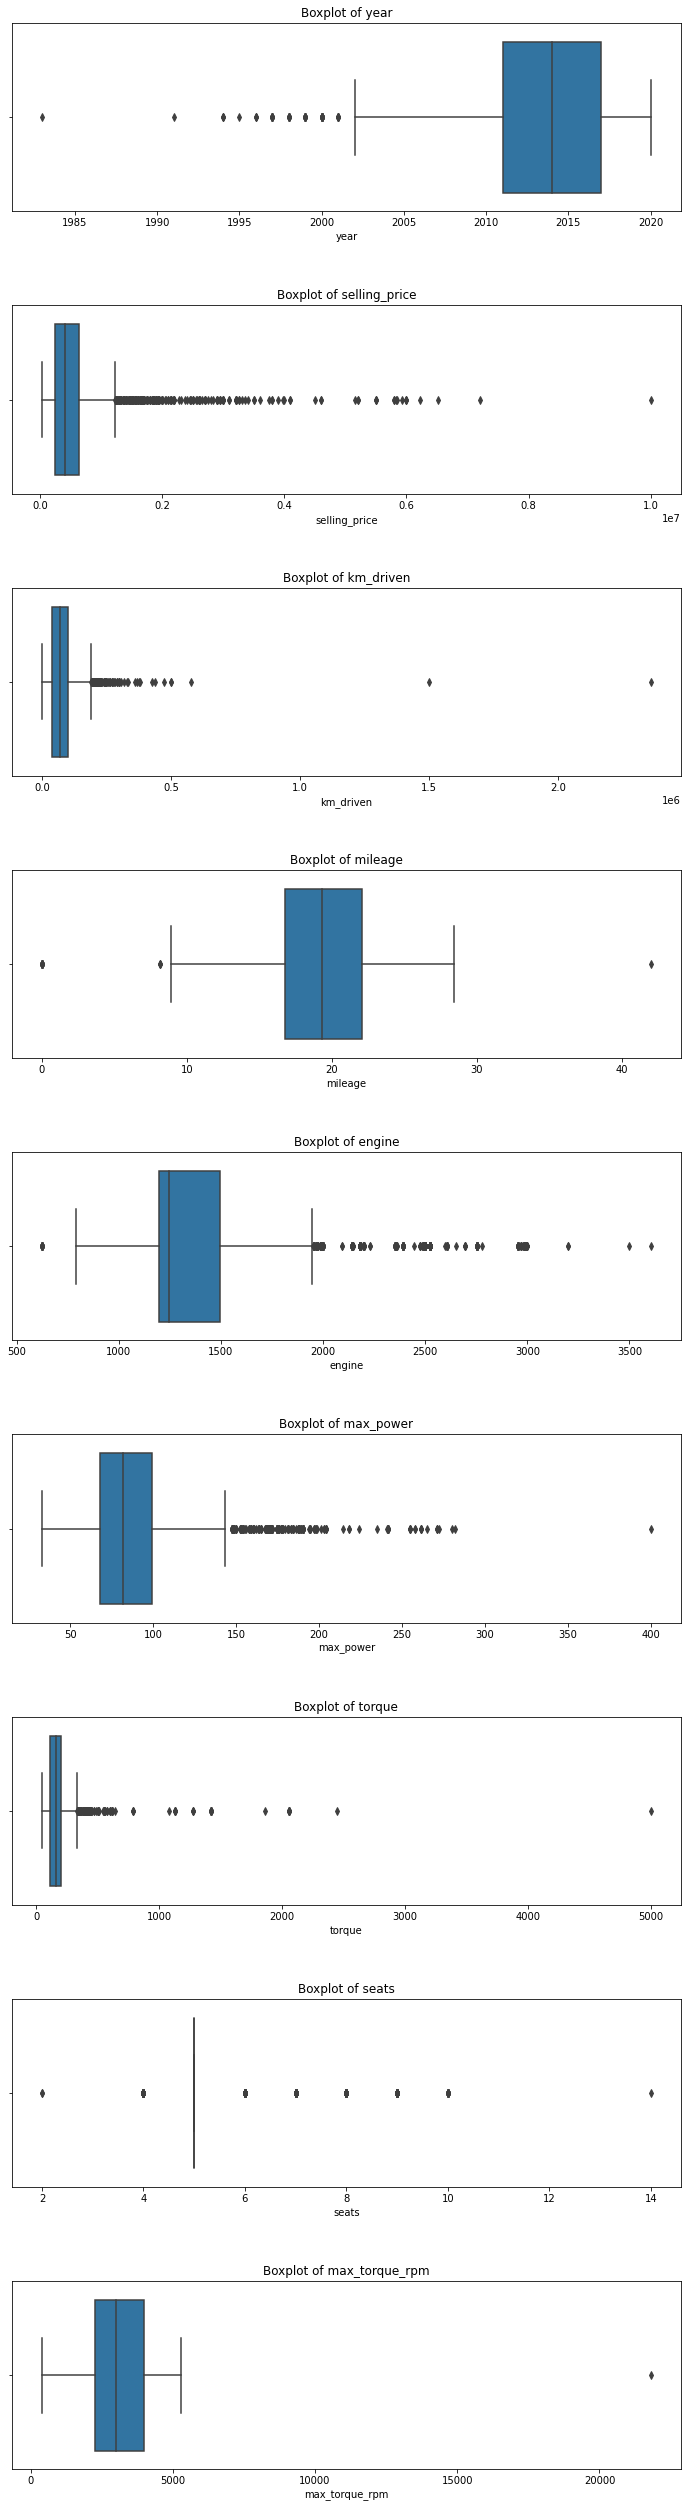

In [43]:
fig, axes = plt.subplots(nrows=len(numeric_columns), figsize=(12, 5 * len(numeric_columns)))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(numeric_columns):
    # Plot boxplot for the column
    sns.boxplot(x=df_train[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

plt.show()

В данных много выбросов

# Часть 2 (1.25 балла) | Модель только на вещественных признаках

(0.05 балла) <font color='#9933CC'>В переменные ``y_train`` и ``y_test`` запишите значения целевых переменных. Столбцы ``selling_price`` из датафреймов необходимо удалить. Категориальные (все, кроме ``seats``) столбцы тоже.</font>

In [44]:
cols_to_drop = list(df_train.select_dtypes(include=['object']).columns)
cols_to_drop.append('selling_price')

In [45]:
cols_to_drop

['name', 'fuel', 'seller_type', 'transmission', 'owner', 'selling_price']

In [46]:
y_train = df_train['selling_price']
X_train = df_train.drop(cols_to_drop, axis=1)

In [47]:
X_train.shape

(5840, 8)

In [48]:
X_train.columns

Index(['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque',
       'seats', 'max_torque_rpm'],
      dtype='object')

In [684]:
assert X_train.shape == (5840, 8)

In [50]:
y_test = df_test['selling_price']
X_test = df_test.drop(cols_to_drop, axis=1)

In [686]:
assert X_test.shape == (1000, 8)

(0.2 балла) <font color='#9933CC'>Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и MSE для трейна и для теста</font>

**Замечание:** $R^2$ и MSE для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [157]:
def save_model(model, file_name: str, directory='models'):
    try:
        if not os.path.isdir(directory):
            os.mkdir(directory)        
            print(f'Created directory {directory}')

        file_path = os.path.join(directory, file_name)
        with open(file_path, 'wb') as file:
            pickle.dump(model, file)
        print(f"Model data saved to {file_path}")
    except Exception as e:
        print(f"Error saving data: {e}")

def load_model(file_name: str , directory='models'):
    file_path = os.path.join(os.getcwd(), directory, file_name)
    with open(file_path, 'rb') as file:
        model = pickle.load(file)
    return model

Запомните правило:

> Использую линейную модель -- стандартизирую фичи

(0.25 балла) <font color='#9933CC'>Воспользуемся им</font>


In [51]:
scaler_x = StandardScaler()
X_train_sc = scaler_x.fit_transform(X_train)
X_test_sc = scaler_x.transform(X_test)

In [53]:
linear_regression = LinearRegression()

In [54]:
linear_regression.fit(X_train_sc, y_train)

LinearRegression()

In [55]:
y_preds = linear_regression.predict(X_test_sc)

In [56]:
def calculate_metrics(y_test, y_preds):
    return [r2_score(y_test, y_preds), MSE(y_test, y_preds)]

In [384]:
# эта ячейка с результатами без колонок torque и max_torque_rpm, не воспроизводима))
r2_score_lr, mse_lr = calculate_metrics(y_preds)
print(f'R2 score: {r2_score_lr}')
print(f'MSE: {mse_lr}')

R2 score: 0.5944598268985283
MSE: 233116071957.2837


In [57]:
print(f'R2 score: {calculate_metrics(y_test, y_preds)[0]}')
print(f'MSE: {calculate_metrics(y_test, y_preds)[1]}')

R2 score: 0.6059808486074731
MSE: 226493459688.8517


Не очень результативно.

Зато уже сейчас можем интерпретировать модель. <font color='#FF6600'>"Какой признак оказался наиболее информативным в предсказании цены?"</font>

In [58]:
def create_feature_importance(X_train, model):
    features = X_train.columns.tolist()
    coefs = model.coef_
    feature_importance = pd.DataFrame({'features': features, 'weights': coefs}).sort_values('weights', ascending=False)
    return feature_importance

In [59]:
fi_lr = create_feature_importance(X_train, linear_regression)
fi_lr.head()

,features,weights
4,max_power,331607.867488
0,year,167377.652462
3,engine,15136.502524
5,torque,9956.328185
2,mileage,-13987.496109


Наиболее информативнм является признак `max_power`

## Сохраним модель

In [714]:
def add_params(model, scaler = None):
    model_params = {
    'coefficients': model.coef_,
    'intercept': model.intercept_
    }
    
    if scaler:
        model_params.update({'scaler_mean': scaler.mean_,
                            'scaler_scale': scaler.scale_,
                            'scaler_features': scaler.feature_names_in_
                            })

    return model_params

In [723]:
# save_params = add_params(linear_regression, scaler_x)
save_model(linear_regression, file_name='linreg_num_only.pkl')

Model data saved to models/linreg_num_only.pkl


Проверка работоспособности:

In [732]:
lr_test = load_model('linreg_num_only.pkl')
lr_test.coef_

array([167377.65246177, -49155.21066119, -13987.496109  ,  15136.50252391,
       331607.86748812,   9956.32818489, -29731.13337354, -64853.83021475])

In [734]:
save_model(scaler_x, file_name='scaler.pkl')

Model data saved to models/scaler.pkl


In [735]:
sc_x_test = load_model('scaler.pkl')

In [736]:
X_test_scaled = sc_x_test.transform(X_test)

In [737]:
y_preds_test = lr_test.predict(X_test_scaled)
print(f'R2 score: {calculate_metrics(y_test, y_preds_test)[0]}')
print(f'MSE: {calculate_metrics(y_test, y_preds_test)[1]}')

R2 score: 0.6059808486074731
MSE: 226493459688.8517


(0.25 балла) <font color='#9933CC'>Теперь попробуем Lasso-регрессию.</font> Здесь и дальше обучайте модели на нормализованных признаках

In [60]:
lasso_regression = Lasso() 
lasso_regression.fit(X_train_sc, y_train)
y_preds_lasso = lasso_regression.predict(X_test_sc)

In [386]:
# опять же без колонок
print(f'R2 score: {calculate_metrics(y_test, y_preds_lasso)[0]}')
print(f'MSE: {calculate_metrics(y_test, y_preds_lasso)[1]}')

R2 score: 0.5944586643634776
MSE: 233116740215.62775


In [61]:
print(f'R2 score: {calculate_metrics(y_test, y_preds_lasso)[0]}')
print(f'MSE: {calculate_metrics(y_test, y_preds_lasso)[1]}')

R2 score: 0.605979429390151
MSE: 226494275495.49518


In [740]:
save_model(lasso_regression, file_name='lasso_num_only.pkl')

Model data saved to models/lasso_num_only.pkl


<font color='#FF6600'>Занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Почему же?</font>

In [741]:
fi_lasso = create_feature_importance(X_train, lasso_regression)
fi_lasso.head()

,features,weights
4,max_power,331609.076852
0,year,167375.456722
3,engine,15134.474174
5,torque,9955.852807
2,mileage,-13984.230189


Ни один из весов не равен 0, значит не занулила. По умолчанию alpha = 1, вероятно значение alpha слишком маленькое, т.к веса даже не уменьшились (нет штрафа) по сравнению с линейной регрессией 

(0.25 балла) <font color='#9933CC'>Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии</font>

Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [742]:
param_grid = {'alpha': np.logspace(1, 7, 7, base=5)}

lasso_grid = GridSearchCV(lasso_regression, param_grid, cv=10)

start_time = time.time()
lasso_grid.fit(X_train_sc, y_train)
end_time = time.time()

In [743]:
best_params = lasso_grid.best_params_
best_lasso = lasso_grid.best_estimator_
elapsed_time = end_time - start_time

print(f"Best Parameters: {best_params}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print(best_lasso)

Best Parameters: {'alpha': 15625.0}
Elapsed Time: 12.63 seconds
Lasso(alpha=15625.0)


### Попробуем найти более точное

In [64]:
def grid_search(distribution):
    param_grid = {'alpha': distribution}

    lasso_grid = GridSearchCV(lasso_regression, 
                              param_grid, 
                              cv=10,
                             n_jobs=32)

    start_time = time.time()
    lasso_grid.fit(X_train_sc, y_train)
    end_time = time.time()
    return start_time, end_time, lasso_grid

In [65]:
start, end, lasso_grid = grid_search(np.logspace(3, 7, 100, base=5))
elapsed_time = end - start
best_params = lasso_grid.best_params_
best_lasso = lasso_grid.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print(best_lasso)

Best Parameters: {'alpha': 22709.46989903945}
Elapsed Time: 31.29 seconds
Lasso(alpha=22709.46989903945)


<font color='#FF6600'>Сколько грид-сёрчу пришлось обучать моделей?</font>

In [62]:
print(f'В первый грид серч обучилось {len(np.logspace(1, 7, 7, base=5)) * 10} моделей, во второй раз - {len(np.logspace(3, 7, 100, base=5)) * 10}')

В первый грид серч обучилось 70 моделей, во второй раз - 1000


<font color='#FF6600'>Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?</font>

Коэффициент alpha=22709.47, да, занулилось три признака

In [66]:
lasso_grid = Lasso(**best_params)
lasso_grid.fit(X_train_sc, y_train)
y_preds_lasso_grid = lasso_grid.predict(X_test_sc)

In [445]:
# без колонок, не воспроизводимо
r2_score_lasso_grid, mse_lasso_grid = calculate_metrics(y_preds_lasso_grid)
print(f'R2 score: {r2_score_lasso_grid}')
print(f'MSE: {mse_lasso_grid}')

R2 score: 0.5641103359034696
MSE: 250561826030.33524


In [747]:
print(f'R2 score: {calculate_metrics(y_test, y_preds_lasso_grid)[0]}')
print(f'MSE: {calculate_metrics(y_test, y_preds_lasso_grid)[1]}')

R2 score: 0.5765240865134353
MSE: 243426047697.15274


In [67]:
fi_lasso_grid = create_feature_importance(X_train, lasso_grid)
fi_lasso_grid.head()

,features,weights
4,max_power,325444.052344
0,year,146817.359279
2,mileage,0.000000
3,engine,0.000000
5,torque,0.000000


Wow, занулилось сразу три признака.

Не wow: метрики стали хуже

(0.25 балла) <font color='#9933CC'>Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)-регрессии</font>

In [752]:
elasticnet = ElasticNet()

elastic_param_grid = {
    'alpha': np.logspace(3, 7, 100, base=5),
    'l1_ratio': np.linspace(0.1, 1, 10)
}

elastic_grid_search = GridSearchCV(elasticnet,
                           param_grid=elastic_param_grid, 
                           cv=10,                 
                           n_jobs=32            
)

In [753]:
start_time = time.time()
elastic_grid_search.fit(X_train_sc, y_train)
end_time = time.time()

In [754]:
elapsed_time = end_time - start_time

print("Best Parameters:", elastic_grid_search.best_params_)
print("Best Negative Mean Squared Error:", elastic_grid_search.best_score_)
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Best Parameters: {'alpha': 22709.46989903945, 'l1_ratio': 1.0}
Best Negative Mean Squared Error: 0.5851530774082427
Elapsed Time: 78.68 seconds


In [ ]:
lasso_grid

In [759]:
elastic_grid = ElasticNet(**elastic_grid_search.best_params_)
elastic_grid.fit(X_train_sc, y_train)
y_preds_elastic_grid = elastic_grid.predict(X_test_sc)

In [761]:
print(f'R2 score: {calculate_metrics(y_test, y_preds_elastic_grid)[0]}')
print(f'MSE: {calculate_metrics(y_test, y_preds_elastic_grid)[1]}')

R2 score: 0.5765240865134353
MSE: 243426047697.15274


In [764]:
fi_lasso_grid = create_feature_importance(X_train, elastic_grid)
fi_lasso_grid.head()

,features,weights
4,max_power,325444.052344
0,year,146817.359279
2,mileage,0.000000
3,engine,0.000000
5,torque,0.000000


<font color='#FF6600'>Какие гиперпараметры соответствуют лучшей из перебранных моделей?</font>

Лучшая модель среди всех выше - простая линейная регрессия с дефолтными гиперпараметрами 
Лучшая модель после подбора гиперпараметров - ну после подобора они дают одинаковый результат с параметрами ниже

In [767]:
elastic_grid_search.best_params_

{'alpha': 22709.46989903945, 'l1_ratio': 1.0}

Предлагаем вам оставить вам попытки заметно улучшить качество модели регуляризацией и перейти к следующей части задания.

# Часть 3 (0.5 балла) | Добавляем категориальные фичи



(0 баллов) <font color='#9933CC'>Из ``df_train`` удалите столбцы с целевой переменной и названием автомобиля.</font>

In [68]:
cols_to_drop_cat = ['selling_price', 'name']
X_train_cat = df_train.drop(cols_to_drop_cat, axis=1)
X_test_cat = df_test.drop(cols_to_drop_cat, axis=1)

In [69]:
num_cols = list(X_train_cat.select_dtypes(exclude = 'object').columns)
num_cols

['year',
 'km_driven',
 'mileage',
 'engine',
 'max_power',
 'torque',
 'seats',
 'max_torque_rpm']

In [804]:
assert X_train_cat.shape == (5840, 12)

In [798]:
assert X_test_cat.shape == (1000, 12)

In [70]:
cat_cols = list(X_train_cat.describe(include='object').columns)
cat_cols.append('seats')

In [71]:
cat_cols

['fuel', 'seller_type', 'transmission', 'owner', 'seats']

(0.5 балла) <font color='#9933CC'>Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования</font>

> Обратите внимание, что во избежание мультиколлинеарности следует избавиться от одного из полученных столбцов при кодировании каждого признака методом OneHot. 

In [72]:
for col in cat_cols:
    X_train_cat[col] = X_train_cat[col].astype('category')
    X_test_cat[col] = X_test_cat[col].astype('category')

In [75]:
ohe = OneHotEncoder(drop='first', sparse = False)
ohe.fit(X_train_cat[cat_cols])

OneHotEncoder(drop='first', sparse=False)

In [76]:
import joblib

In [77]:
def one_hot_enc(df, cat_cols, ohe=None, model_path='ohe_model.pkl'):
    if ohe is None:
        ohe = joblib.load(model_path)

    cat_features = df[cat_cols]
    num_features = df.drop(columns=cat_cols)

    if not cat_features.empty:
        values = ohe.transform(cat_features)
        labels = ohe.get_feature_names_out()
        df_encoded = pd.DataFrame(values, columns=labels, index=df.index)
    else:
        df_encoded = pd.DataFrame()

    df_result = pd.concat([num_features, df_encoded], axis=1)

    return df_result

In [78]:
X_train_enc = one_hot_enc(X_train_cat, cat_cols, ohe)
X_test_enc = one_hot_enc(X_test_cat, cat_cols, ohe)

In [79]:
X_train_enc.head()

,year,km_driven,mileage,engine,max_power,torque,max_torque_rpm,fuel_Diesel,fuel_LPG,fuel_Petrol,...,owner_Test Drive Car,owner_Third Owner,seats_4,seats_5,seats_6,seats_7,seats_8,seats_9,seats_10,seats_14
0,2014,145500,23.40,1248,74.00,190.00,2000.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014,120000,21.14,1498,103.52,250.00,2500.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010,127000,23.00,1396,90.00,219.67,2750.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2007,120000,16.10,1298,88.20,112.78,4500.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017,45000,20.14,1197,81.86,113.75,4000.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
scaler_cat = StandardScaler()
X_train_cat_sc = scaler_cat.fit_transform(X_train_enc)
X_test_cat_sc = scaler_cat.transform(X_test_enc)

(0.25 балла) <font color='#9933CC'>Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV`.</font> В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.

<font color='#FF6600'>Удалось ли улучшить качество предсказаний?</font>

In [81]:
r2_scorer = make_scorer(r2_score)
ridge = Ridge()

ridge_param_grid = {
    'alpha': np.logspace(2, 7, 200, base=5),
}

ridge_grid_search = GridSearchCV(ridge,
                                 param_grid=ridge_param_grid, 
                                 scoring=r2_scorer,
                                 cv=10,                 
                                 n_jobs=32
)

In [82]:
start_time = time.time()
ridge_grid_search.fit(X_train_cat_sc, y_train)
end_time = time.time()

In [859]:
start_time = time.time()
ridge_grid_search.fit(X_train_enc, y_train)
end_time = time.time()

In [83]:
elapsed_time = end_time - start_time

print("Best Parameters:", ridge_grid_search.best_params_)
print("Best Negative Mean Squared Error:", ridge_grid_search.best_score_)
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Best Parameters: {'alpha': 459.6299904006378}
Best Negative Mean Squared Error: 0.6284990505954672
Elapsed Time: 40.54 seconds


In [860]:
elapsed_time = end_time - start_time

print("Best Parameters:", ridge_grid_search.best_params_)
print("Best Negative Mean Squared Error:", ridge_grid_search.best_score_)
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Best Parameters: {'alpha': 25.0}
Best Negative Mean Squared Error: 0.6282685940426933
Elapsed Time: 46.42 seconds


In [85]:
ridge_grid = Ridge(**ridge_grid_search.best_params_)
ridge_grid.fit(X_train_cat_sc, y_train)
y_preds_ridge_grid = ridge_grid.predict(X_test_cat_sc)

In [862]:
ridge_grid = Ridge(**ridge_grid_search.best_params_)
ridge_grid.fit(X_train_enc, y_train)
y_preds_ridge_grid = ridge_grid.predict(X_test_enc)

In [86]:
print(f'R2 score: {calculate_metrics(y_test, y_preds_ridge_grid)[0]}')
print(f'MSE: {calculate_metrics(y_test, y_preds_ridge_grid)[1]}')

R2 score: 0.6254061395856241
MSE: 215327247733.02475


In [863]:
print(f'R2 score: {calculate_metrics(y_test, y_preds_ridge_grid)[0]}')
print(f'MSE: {calculate_metrics(y_test, y_preds_ridge_grid)[1]}')

R2 score: 0.659142407762671
MSE: 195934677424.1817


In [548]:
r2_score_ridge_grid, mse_ridge_grid = calculate_metrics(y_preds_ridge_grid)
print(f'R2 score: {r2_score_ridge_grid}')
print(f'MSE: {mse_ridge_grid}')

R2 score: 0.1920280061171179
MSE: 464445374240.0111


In [870]:
fi_ridge_grid = create_feature_importance(X_train_enc, ridge_grid)
fi_ridge_grid.head()

,features,weights
4,max_power,249531.953278
0,year,143948.472915
15,owner_Test Drive Car,81516.305536
17,seats_4,57269.592848
3,engine,54167.413340


# Часть 4 - бонусная (1.5 балла) | Feature Engineering 

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

## 1.Сгенерировать новые признаки на основе уже существующих

### число "лошадей" на литр объема

In [87]:
df_train['power_per_l'] = df_train['max_power'] / df_train['engine']
df_test['power_per_l'] = df_test['max_power'] / df_test['engine']
df_train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm,power_per_l
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.00,5,2000.0,0.059295
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.00,5,2500.0,0.069105
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,219.67,5,2750.0,0.064470
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,112.78,5,4500.0,0.067951
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197,81.86,113.75,5,4000.0,0.068388


### квадрат признака `year`

In [127]:
df_train['sq_year'] = df_train['year'] ** 2
df_test['sq_year'] = df_test['year'] ** 2

In [128]:
cols_to_drop_cat = ['selling_price', 'name']
X_train_cat_mod = df_train.drop(cols_to_drop_cat, axis=1)
X_test_cat_mod = df_test.drop(cols_to_drop_cat, axis=1)

In [94]:
num_cols = list(X_train_cat_mod.select_dtypes(exclude = 'object').columns)
num_cols

['year',
 'km_driven',
 'mileage',
 'engine',
 'max_power',
 'torque',
 'seats',
 'max_torque_rpm',
 'power_per_l',
 'sq_year']

In [112]:
cat_cols

['fuel', 'seller_type', 'transmission', 'owner', 'seats']

In [96]:
for col in cat_cols:
    X_train_cat_mod[col] = X_train_cat_mod[col].astype('category')
    X_test_cat_mod[col] = X_test_cat_mod[col].astype('category')

In [97]:
ohe_modified = OneHotEncoder(drop='first', sparse = False)
ohe_modified.fit(X_train_cat_mod[cat_cols])

OneHotEncoder(drop='first', sparse=False)

In [98]:
X_train_enc_mod = one_hot_enc(X_train_cat_mod, cat_cols, ohe_modified)
X_test_enc_mod = one_hot_enc(X_test_cat_mod, cat_cols, ohe_modified)

In [99]:
scaler_cat = StandardScaler()
X_train_cat_sc_mod = scaler_cat.fit_transform(X_train_enc_mod)
X_test_cat_sc_mod = scaler_cat.transform(X_test_enc_mod)

In [100]:
ridge = Ridge()

ridge_param_grid_mod = {
    'alpha': np.logspace(2, 7, 200, base=5),
}

ridge_grid_search_mod = GridSearchCV(ridge,
                                 param_grid=ridge_param_grid_mod, 
                                 scoring=r2_scorer,
                                 cv=10,                 
                                 n_jobs=32
)

In [101]:
start_time = time.time()
ridge_grid_search_mod.fit(X_train_cat_sc_mod, y_train)
end_time = time.time()

In [102]:
elapsed_time = end_time - start_time

print("Best Parameters:", ridge_grid_search_mod.best_params_)
print("Best Negative Mean Squared Error:", ridge_grid_search_mod.best_score_)
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Best Parameters: {'alpha': 34.54908038388393}
Best Negative Mean Squared Error: 0.6271247239718857
Elapsed Time: 42.12 seconds


In [105]:
ridge_grid_mod = Ridge(**ridge_grid_search_mod.best_params_)
ridge_grid_mod.fit(X_train_cat_sc_mod, y_train)
y_preds_ridge_grid_mod = ridge_grid_mod.predict(X_test_cat_sc_mod)

In [106]:
print(f'R2 score: {calculate_metrics(y_test, y_preds_ridge_grid_mod)[0]}')
print(f'MSE: {calculate_metrics(y_test, y_preds_ridge_grid_mod)[1]}')

R2 score: 0.641906500303006
MSE: 205842369214.3388


Увеличение до 0.642, оставляем признаки

## 2. Добыть новые признаки

### Название автомобиля

In [109]:
df_train['car_brand'] = df_train.name.apply(lambda x: x.split()[0])
df_test['car_brand'] = df_train.name.apply(lambda x: x.split()[0])

Обучим модель после добавления этого признака

In [110]:
cols_to_drop_cat = ['selling_price', 'name']
X_train_cat_br = df_train.drop(cols_to_drop_cat, axis=1)
X_test_cat_br = df_test.drop(cols_to_drop_cat, axis=1)

In [111]:
num_cols = list(X_train_cat_br.select_dtypes(exclude = 'object').columns)
num_cols

['year',
 'km_driven',
 'mileage',
 'engine',
 'max_power',
 'torque',
 'seats',
 'max_torque_rpm',
 'power_per_l',
 'sq_year']

In [113]:
cat_cols = list(X_train_cat_br.describe(include='object').columns)
cat_cols.append('seats')

In [115]:
for col in cat_cols:
    X_train_cat_br[col] = X_train_cat_br[col].astype('category')
    X_test_cat_br[col] = X_test_cat_br[col].astype('category')

In [116]:
ohe_modified_br = OneHotEncoder(drop='first', sparse = False)
ohe_modified_br.fit(X_train_cat_br[cat_cols])

OneHotEncoder(drop='first', sparse=False)

In [117]:
X_train_enc_br = one_hot_enc(X_train_cat_br, cat_cols, ohe_modified_br)
X_test_enc_br = one_hot_enc(X_test_cat_br, cat_cols, ohe_modified_br)

In [118]:
scaler_br = StandardScaler()
X_train_cat_sc_br = scaler_br.fit_transform(X_train_enc_br)
X_test_cat_sc_br = scaler_br.transform(X_test_enc_br)

In [119]:
ridge = Ridge()

ridge_param_grid_br = {
    'alpha': np.logspace(2, 7, 200, base=5),
}

ridge_grid_search_br = GridSearchCV(ridge,
                                 param_grid=ridge_param_grid_br, 
                                 scoring=r2_scorer,
                                 cv=10,                 
                                 n_jobs=32
)

In [120]:
start_time = time.time()
ridge_grid_search_br.fit(X_train_cat_sc_br, y_train)
end_time = time.time()

In [121]:
elapsed_time = end_time - start_time

print("Best Parameters:", ridge_grid_search_br.best_params_)
print("Best Negative Mean Squared Error:", ridge_grid_search_br.best_score_)
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Best Parameters: {'alpha': 809.6124983974826}
Best Negative Mean Squared Error: 0.7119778740575059
Elapsed Time: 48.43 seconds


In [122]:
ridge_grid_br = Ridge(**ridge_grid_search_br.best_params_)
ridge_grid_br.fit(X_train_cat_sc_br, y_train)
y_preds_ridge_grid_br = ridge_grid_br.predict(X_test_cat_sc_br)

In [123]:
print(f'R2 score: {calculate_metrics(y_test, y_preds_ridge_grid_br)[0]}')
print(f'MSE: {calculate_metrics(y_test, y_preds_ridge_grid_br)[1]}')

R2 score: 0.4053839687741041
MSE: 341802274389.0459


Признак дал прирост на трейновой выборке, но сильно просело значение R2 на тесте, возможно переобучение. Не будем использовать признак

In [125]:
df_train.drop('car_brand', axis=1, inplace=True)
df_test.drop('car_brand', axis=1, inplace=True)

## 3. Поработать с уже имеющимися:

Попробуем прологарифмировать целевую переменную

In [126]:
y_train_1 = np.log(y_train)
y_test_1 = np.log(y_test)

Мы уменьшили целевую переменную, изменим диапазон альфа

In [148]:
ridge = Ridge()

ridge_param_grid_fin = {
    'alpha': np.logspace(-2, 3, 200, base=5),
}

ridge_grid_search_fin = GridSearchCV(ridge,
                                 param_grid=ridge_param_grid_fin, 
                                 scoring=r2_scorer,
                                 cv=10,                 
                                 n_jobs=32
)

In [149]:
start_time = time.time()
ridge_grid_search_fin.fit(X_train_cat_sc_mod, y_train_1)
end_time = time.time()

In [150]:
elapsed_time = end_time - start_time

print("Best Parameters:", ridge_grid_search_fin.best_params_)
print("Best Negative Mean Squared Error:", ridge_grid_search_fin.best_score_)
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Best Parameters: {'alpha': 0.04}
Best Negative Mean Squared Error: 0.8387147806833722
Elapsed Time: 41.17 seconds


In [151]:
ridge_grid_fin = Ridge(**ridge_grid_search_fin.best_params_)
ridge_grid_fin.fit(X_train_cat_sc_mod, y_train_1)
y_preds_ridge_grid_fin = ridge_grid_fin.predict(X_test_cat_sc_mod)

In [162]:
ridge_grid_fin.coef_

array([-5.30773479e+00, -1.39694735e-02,  3.23700768e-02,  3.38424392e-01,
        3.04978932e-02,  5.56926589e-03, -2.53670567e-02,  2.10154269e-01,
        5.73707757e+00,  6.57073718e-02,  1.30768533e-02, -1.64038760e-02,
       -2.71851467e-02,  2.46629641e-03, -5.37847758e-02, -2.21121227e-02,
       -3.77481898e-02,  2.10794326e-02, -2.74662658e-02,  1.17181505e-02,
        6.14397604e-02,  3.29263275e-04,  7.40539861e-02,  5.46292001e-02,
        1.38443238e-02,  2.50484818e-03, -9.63345430e-04])

In [152]:
print(f'R2 score: {calculate_metrics(y_test_1, y_preds_ridge_grid_fin)[0]}')
print(f'MSE: {calculate_metrics(y_test_1, y_preds_ridge_grid_fin)[1]}')

R2 score: 0.8734878823074426
MSE: 0.09049502352938651


огого, это дало наибольший прирост метрики

In [159]:
ohe_modified.feature_names_in_

array(['fuel', 'seller_type', 'transmission', 'owner', 'seats'],
      dtype=object)

In [158]:
save_model(ohe_modified, 'one_hot_encoder.pkl')

Model data saved to models/one_hot_encoder.pkl


In [160]:
save_model(scaler_cat, 'scaler.pkl')

Model data saved to models/scaler.pkl


In [163]:
save_model(ridge_grid_fin, 'ridge_best_model.pkl')

Model data saved to models/ridge_best_model.pkl


# Часть Бизнесовая (0.5 балла)

Заказчик просил вас посчитать кастомную метрику -- среди всех предсказанных цен на авто посчитать долю предиктов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

<font color='#9933CC'>Сделайте это самостоятельно для лучшей из своих моделей</font>

In [143]:
def business_metrics(y_true, y_pred):
    counts = sum(np.where((np.abs(y_true - y_pred) / y_true) <= 0.1, 1, 0)) / len(y_true)
    return counts

Возьмем модель Ridge c предыдущего пункта

In [156]:
print(business_metrics(y_test, np.exp(y_preds_ridge_grid_fin)))

0.309


# Часть 5 (2.5 балла) | Реализация сервиса на FastAPI

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List
import pandas as pd
from fastapi.responses import FileResponse
from io import BytesIO

app = FastAPI()


class Item(BaseModel):
    name: str
    year: int
    selling_price: int
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str 
    engine: str
    max_power: str
    torque: str
    seats: float


class Items(BaseModel):
    objects: List[Item]


@app.post("/predict_item")
def predict_item(item: Item) -> float:
    return ...


@app.post("/predict_items")
def predict_items(items: List[Item]) -> List[float]:
    pd.read_csv(items)
    return ...

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

app = FastAPI()


class Item(BaseModel):
    name: str
    year: int
    selling_price: int
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str
    engine: str
    max_power: str
    torque: str
    seats: float


class Items(BaseModel):
    objects: List[Item]


@app.post("/predict_item")
def predict_item(item: Item) -> float:
    # Preprocess the input item (you may need to adjust this based on your preprocessing steps)
    input_data = pd.DataFrame([item.dict()])
    input_features = preprocess_input_data(input_data)

    # Load your pre-trained model
    model = load_model()

    # Make a prediction
    prediction = model.predict(input_features)

    return float(prediction[0])


@app.post("/predict_items")
def predict_items(items: Items) -> List[float]:
    # Preprocess the input items (you may need to adjust this based on your preprocessing steps)
    input_data = pd.DataFrame([item.dict() for item in items.objects])
    input_features = preprocess_input_data(input_data)

    # Load your pre-trained model
    model = load_model()

    # Make predictions
    predictions = model.predict(input_features)

    return [float(pred) for pred in predictions]


def preprocess_input_data(data: pd.DataFrame) -> pd.DataFrame:
    # Implement your preprocessing steps here (e.g., handle categorical variables, scaling, etc.)
    # ...

    return processed_data


def load_model() -> LinearRegression:
    # Load and return your pre-trained machine learning model
    # ...

    return model

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# Часть 6 (1 балл) | Оформление результатов

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете прислать screencast в ТГ
3. Просматривает ноутбук с pure-DS частью
4. Заглядывает в код сервиса
5. Хвалит

# Часть Благодарственная

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

https://drive.google.com/file/d/1LT06nyg9QgVi3r-D5BY-_mQ9TcJQFxJN/view?usp=share_link

In [166]:
oo = pd.read_csv('https://raw.githubusercontent.com/hse-mlds/ml/main/hometasks/HT1/cars_test.csv')
oo.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0 kmpl,2498 CC,112 bhp,260 Nm at 1800-2200 rpm,7.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9 kmpl,1799 CC,130 bhp,172Nm@ 4300rpm,5.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5 kmpl,1172 CC,65 bhp,96 Nm at 3000 rpm,5.0


In [169]:
ooo = pd.read_csv('../fixture/test_sample.csv')
ooo.head(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Tata Tigor 1.2 Revotron XZ Option,2017,600000,40000,Petrol,Individual,Manual,Second Owner,20.3 kmpl,1199 CC,84 bhp,114Nm@ 3500rpm,5.0
1,Tata Nano Cx BSIII,2012,60000,40000,Petrol,Individual,Manual,Second Owner,25.4 kmpl,624 CC,38 bhp,51Nm@ 4000+/-500rpm,4.0
2,Hyundai EON Era Plus,2013,180000,60000,Petrol,Individual,Manual,First Owner,21.1 kmpl,814 CC,55.2 bhp,74.5Nm@ 4000rpm,5.0
3,Jeep Compass 2.0 Limited,2017,1650000,50000,Diesel,Individual,Manual,First Owner,17.1 kmpl,1956 CC,170 bhp,350Nm@ 1750-2500rpm,5.0
4,Mahindra XUV500 W10 2WD,2016,1350000,25000,Diesel,Individual,Manual,First Owner,16.0 kmpl,2179 CC,140 bhp,330Nm@ 1600-2800rpm,7.0
5,Maruti Wagon R VXI BS IV,2008,135000,90000,Petrol,Individual,Manual,Second Owner,18.9 kmpl,998 CC,67.1 bhp,90Nm@ 3500rpm,5.0
6,Maruti Swift Dzire ZDI,2012,625000,100000,Diesel,Individual,Manual,Second Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
7,Maruti Alto K10 2010-2014 VXI,2012,275000,50000,Petrol,Individual,Manual,First Owner,20.92 kmpl,998 CC,67.1 bhp,90Nm@ 3500rpm,5.0
8,Ford EcoSport 1.5 Diesel Ambiente BSIV,2018,750000,17000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1498 CC,98.96 bhp,205Nm@ 1750-3250rpm,5.0
9,Maruti 800 Std,2006,114999,59000,Petrol,Individual,Manual,Second Owner,16.1 kmpl,796 CC,37 bhp,59Nm@ 2500rpm,4.0


In [170]:
ooo.iloc[7,:]

name             Maruti Alto K10 2010-2014 VXI
year                                      2012
selling_price                           275000
km_driven                                50000
fuel                                    Petrol
seller_type                         Individual
transmission                            Manual
owner                              First Owner
mileage                             20.92 kmpl
engine                                  998 CC
max_power                             67.1 bhp
torque                           90Nm@ 3500rpm
seats                                      5.0
Name: 7, dtype: object

In [173]:
ooo.loc[6].to_json("test_row.json")

In [888]:
ooo = oo.sample(10)

In [889]:
ooo.to_csv('test_sample.csv', index=False)